<a href="https://colab.research.google.com/github/ParvathyPadmanabhan/SentimentAnsalysis/blob/main/Sentiment_Analysis_BERT_NB_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/My Drive/Reviews_Amazon.csv"
df = pd.read_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [6]:
def preprocess_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
df["preprocessed_text"] = df["reviews.text"].apply(preprocess_text)

In [9]:
# Print the first few rows of the dataset
print(df.head())

                     id             dateAdded           dateUpdated  \
0  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
1  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
2  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
3  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
4  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   

                                                name                  asins  \
0  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
1  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
2  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
3  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
4  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   

          brand                                         categories  \
0  Amazonbasics  AA,AAA,Heal

In [10]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
# Analyse the sentiment of each review and give score
sia = SentimentIntensityAnalyzer()
sentiment_scores = df['preprocessed_text'].apply(lambda x: sia.polarity_scores(x))
df['positive_sentiment'] = sentiment_scores.apply(lambda x: x['pos'])
df['negative_sentiment'] = sentiment_scores.apply(lambda x: x['neg'])
df['neutral_sentiment'] = sentiment_scores.apply(lambda x: x['neu'])
df['compound_sentiment'] = sentiment_scores.apply(lambda x: x['compound'])

In [12]:
# Mapping score to sentiment
threshold_positive = 0.1
threshold_negative = -0.1
def map_sentiment(score):
    if score > threshold_positive:
        return 2
    elif score < threshold_negative:
        return 0
    else:
        return 1
# Apply the function to create sentiment labels
df['sentiment_label'] = df['compound_sentiment'].apply(map_sentiment)

In [13]:
# Check the distribution of sentiments
sentiment_counts = df["sentiment_label"].value_counts()
print(sentiment_counts)

2    23943
1     2748
0     1641
Name: sentiment_label, dtype: int64


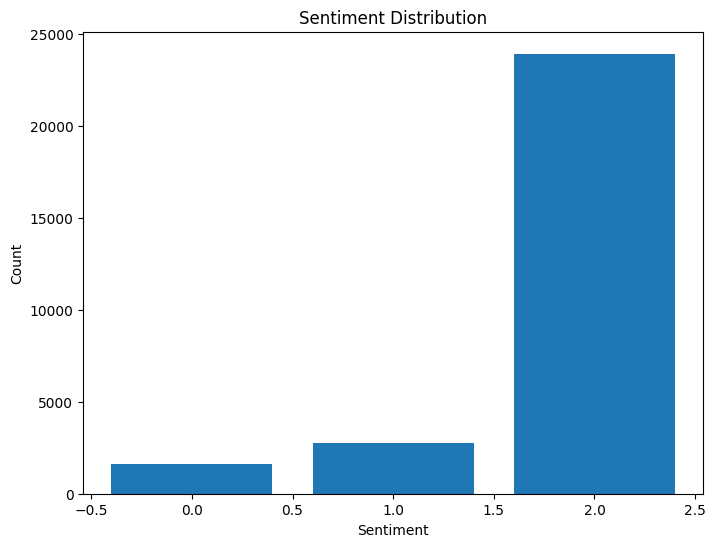

In [14]:
# Visualization
# Bar plot for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

In [15]:
# Word Cloud Visualization
# Combine all the preprocessed text into a single string
all_text = " ".join(df["preprocessed_text"])

In [16]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

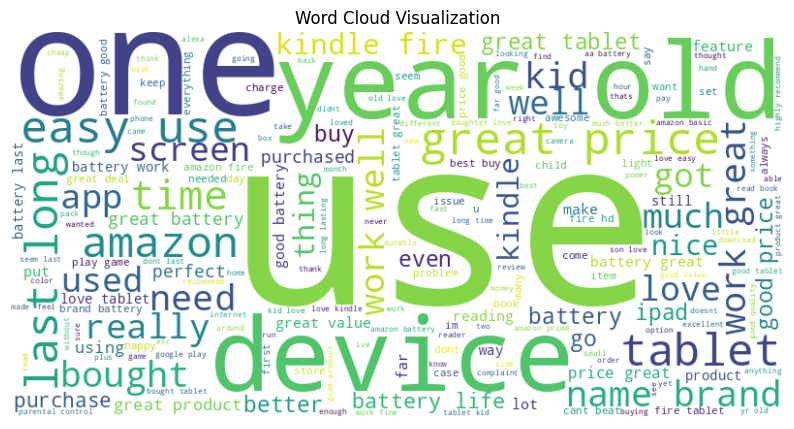

In [17]:
# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Visualization")
plt.show()

In [18]:
#BERT Tranformer

In [19]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
reviews = df["preprocessed_text"].tolist()
labels = df["sentiment_label"].tolist()

In [21]:
inputs = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")
dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, torch.tensor(labels))

In [22]:
# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [23]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
# Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
for epoch in range(5):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, label = batch
        input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{5}, Average Loss: {avg_loss:.4f}")

Epoch 1/5, Average Loss: 0.2261
Epoch 2/5, Average Loss: 0.0884
Epoch 3/5, Average Loss: 0.0538
Epoch 4/5, Average Loss: 0.0362
Epoch 5/5, Average Loss: 0.0268


In [25]:
model.eval()
true_labelsBert = []
predicted_labelsBert = []
with torch.no_grad():
      for batch in test_loader:
          input_ids, attention_mask, label = batch
          input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)
          outputs = model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          predictions = torch.argmax(logits, dim=1)
          true_labelsBert.extend(label.cpu().numpy())
          predicted_labelsBert.extend(predictions.cpu().numpy())

In [26]:
# Calculate evaluation metrics
accuracyBERT = accuracy_score(true_labelsBert, predicted_labelsBert)
reportBERT = classification_report(true_labelsBert, predicted_labelsBert, target_names=["Neutral", "Positive", "Negative"])
cmBERT = confusion_matrix(true_labelsBert, predicted_labelsBert)
print(f"Accuracy: {accuracyBERT}")
print("Classification Report:")
print(reportBERT)

Accuracy: 0.9740603493912123
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.85      0.88      0.87       314
    Positive       0.94      0.85      0.89       576
    Negative       0.99      1.00      0.99      4777

    accuracy                           0.97      5667
   macro avg       0.93      0.91      0.92      5667
weighted avg       0.97      0.97      0.97      5667



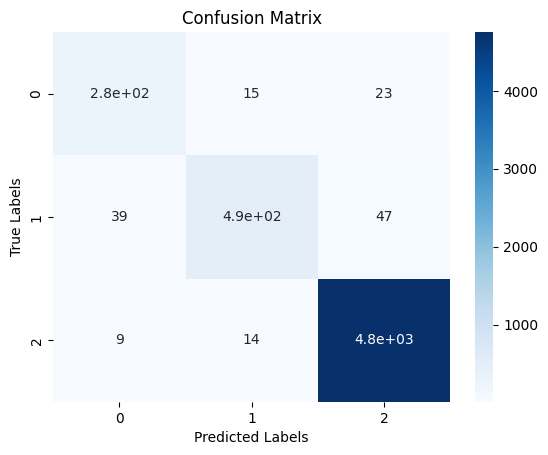

In [28]:
class_labels = np.unique(true_labelsBert)
sns.heatmap(cmBERT, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Naive Bayes Classifier

In [30]:
reviews = df["preprocessed_text"].tolist()
sentiments = df["sentiment_label"].tolist()

In [31]:
# Split dataset into train and test sets
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews, sentiments, test_size=0.2, random_state=42
)

In [32]:
# Create TF-IDF features
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_reviews)
test_features = vectorizer.transform(test_reviews)

In [33]:
# Train Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(train_features, train_sentiments)

MultinomialNB()

In [34]:
# Make predictions
predicted_sentiments = classifier.predict(test_features)

In [35]:
predicted_sentiments

array([2, 2, 2, ..., 2, 2, 2])

In [36]:
# Calculate evaluation metrics
accuracyNB = accuracy_score(test_sentiments, predicted_sentiments)
reportNB = classification_report(test_sentiments, predicted_sentiments, target_names=["Negative", "Neutral", "Positive"])
conf_matrixNB = confusion_matrix(test_sentiments, predicted_sentiments)

In [37]:
print(f"Accuracy: {accuracyNB}")
print("Classification Report:")
print(reportNB)

Accuracy: 0.837833068643021
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       349
     Neutral       1.00      0.02      0.03       581
    Positive       0.84      1.00      0.91      4737

    accuracy                           0.84      5667
   macro avg       0.95      0.34      0.32      5667
weighted avg       0.86      0.84      0.77      5667



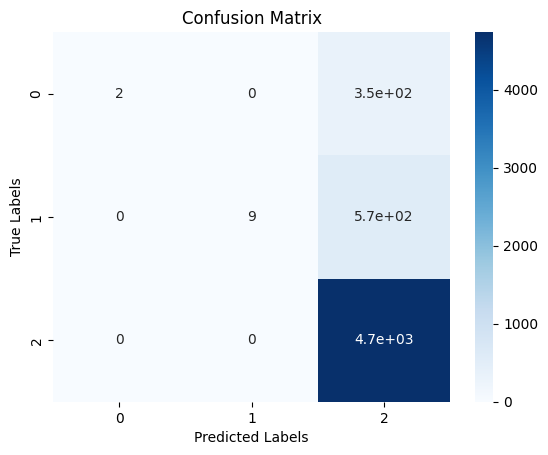

In [38]:
class_labels = np.unique(sentiments)
sns.heatmap(conf_matrixNB, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
#RNN

In [40]:
# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [41]:
# Pad sequences to have the same length
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [42]:
# Convert the labels to a NumPy array
labels = np.array(sentiments)

In [43]:
# Split dataset into train and test sets
train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_length),
    tf.keras.layers.LSTM(64, return_sequences=True),  # Add an LSTM layer with return_sequences=True
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Three output neurons for three sentiments
])

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model
model.fit(train_sequences, train_labels, epochs=5, batch_size=32)

Epoch 1/5
709/709 [==============================] - 63s 81ms/step - loss: 0.5226 - accuracy: 0.8447
Epoch 2/5
709/709 [==============================] - 25s 36ms/step - loss: 0.5029 - accuracy: 0.8470
Epoch 3/5
709/709 [==============================] - 22s 31ms/step - loss: 0.5154 - accuracy: 0.8474
Epoch 4/5
709/709 [==============================] - 19s 27ms/step - loss: 0.5305 - accuracy: 0.8474
Epoch 5/5
709/709 [==============================] - 17s 25ms/step - loss: 0.5040 - accuracy: 0.8477


In [47]:
# Evaluate the model on the test set
loss, accuracyRNN = model.evaluate(test_sequences, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracyRNN}")

178/178 [==============================] - 2s 11ms/step - loss: 0.5565 - accuracy: 0.8359
Test Loss: 0.5565497875213623, Test Accuracy: 0.8358920216560364


In [48]:
# Make predictions on the test set
predictions = model.predict(test_sequences)
predictions = np.argmax(predictions, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

178/178 [==============================] - 2s 9ms/step


In [49]:
one_hot_test_labels = to_categorical(test_labels, num_classes=3)

In [50]:
# Calculate accuracy
accuracyRNN = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracyRNN:.4f}")

Accuracy: 0.8359


In [51]:
# Calculate precision, recall, and f1-score for all classes
reportRNN = classification_report(test_labels, predictions, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:")
print(reportRNN)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       349
     Neutral       0.00      0.00      0.00       581
    Positive       0.84      1.00      0.91      4737

    accuracy                           0.84      5667
   macro avg       0.28      0.33      0.30      5667
weighted avg       0.70      0.84      0.76      5667



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Calculate confusion matrix
cmRNN = confusion_matrix(one_hot_test_labels.argmax(axis=1), predictions, labels=[0, 1, 2])

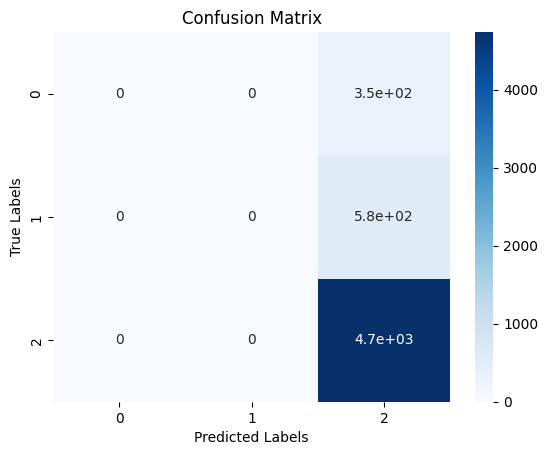

In [53]:
class_labels = np.unique(sentiments)
sns.heatmap(cmRNN, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()